Import dependencies

In [166]:
from model.layers import GraphSpectralFilterLayer, AnalysisFilter
from model.spectral_filter import Graph
import torch
import torch.nn.functional as F
from torch import nn
from random import seed as rseed
from numpy.random import seed as nseed
from citation import get_planetoid_dataset, random_planetoid_splits, run
from citation.train_eval import evaluate


Define hyperparameters

In [167]:
dataset_name = 'Cora'

random_splits = False
runs = 1
epochs =400
alpha =0.2
seed =729
lr =0.005
weight_decay =0.0005
early_stopping=50
hidden=32
heads =12
dropout=0.75
normalize_features =True
pre_training = False
cuda = False
chebyshev_order =16
edge_dropout =0
node_feature_dropout =0
filter ='analysis'

rseed(seed)
nseed(seed)
torch.manual_seed(seed)

cuda = cuda and torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

Define model

In [168]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        data = dataset.data
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter,
                                                 pre_training=pre_training, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, chebyshev_order=chebyshev_order)
        # self.mlp = nn.Sequential(nn.Linear(hidden * heads, 128),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(128, 64),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(64, 32),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(32, dataset.num_classes),
        #                             nn.ReLU(inplace=True))

        # self.W = torch.zeros(hidden * heads, dataset.num_classes)

        self.synthesis = GraphSpectralFilterLayer(self.G, hidden * heads, dataset.num_classes, filter=filter,
                                                  device='cuda' if cuda else 'cpu', dropout=dropout,
                                                  out_channels=1, alpha=alpha, pre_training=False,
                                                  chebyshev_order=chebyshev_order)

    def reset_parameters(self):
        self.analysis.reset_parameters()
        # torch.nn.init.xavier_uniform_(self.W.data, gain=1.414)
        # for layer in self.mlp:
        #     if hasattr(layer, 'reset_parameters'):
        #         layer.reset_parameters()
        self.synthesis.reset_parameters()

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_2 = self.synthesis(x)
        x = F.elu(x)
        # x = F.elu(x.mm(self.W))
        # x = self.mlp(x)
        return F.log_softmax(x, dim=1), attentions_1, attentions_2


dataset = get_planetoid_dataset(dataset_name, normalize_features, edge_dropout=edge_dropout,
                                node_feature_dropout=node_feature_dropout)
if cuda:
    dataset.data.to('cuda')

# permute_masks = random_planetoid_splits if random_splits else None
# run(dataset, Net(dataset), runs, epochs, lr, weight_decay,
#     early_stopping, permute_masks)

Load trained model and evaluate

In [170]:
model = Net(dataset)
model.load_state_dict(torch.load('./best_{}.pkl'.format(dataset_name)))
filter_kernel = model.analysis.filter_kernel
evaluate(model, dataset.data)

{'train_loss': 0.5188673138618469,
 'train_acc': 0.9602649006622517,
 'val_loss': 2.742414951324463,
 'val_acc': 0.872,
 'test_loss': 3.035338878631592,
 'test_acc': 0.872,
 'f1_score': 0.9113737075332349}

Obtain attention weights in layer 1 and 2

In [171]:
with torch.no_grad():
    _, att1, att2 = model(dataset.data)

In [176]:
from matplotlib import pyplot as plt
def plot_filter_banks(idx=list(range(12)), kernel=model.analysis.filter._kernel):
    plt.figure()
    x = torch.linspace(0, 2, 100)
    plt.plot(x, kernel(x).detach()[:, idx])
    plt.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])
    plt.show()

Plot filterbanks in layer 1 and 2

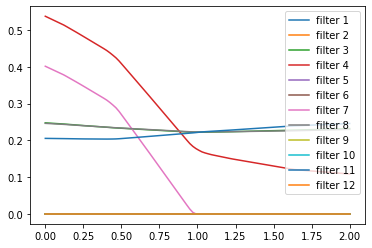

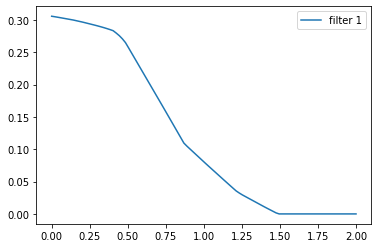

In [177]:
plot_filter_banks(kernel=model.analysis.filter._kernel)
plot_filter_banks(idx=[0], kernel=model.synthesis.filter._kernel)

Define kernel to cut frequency bands abruptly

In [178]:
# Cut frequency bands abruptly
class CutOff(nn.Module):
    def __init__(self, threshold = 1):
        self.threshold = threshold
        super(CutOff, self).__init__()

    def reset_parameters(self):
        pass

    def forward(self, x):
        return torch.where(x.view(-1,1).repeat(1, 12) < self.threshold, torch.zeros(x.shape[0], 12), filter_kernel(x).detach())

Define kernel to eliminate certain fitlerbanks

In [179]:
class Elimination(nn.Module):
    def __init__(self, zero_out_indices):
        super(Elimination, self).__init__()
        self.zero_out_indices = zero_out_indices

    def reset_parameters(self):
        pass

    def forward(self, x):
        x = filter_kernel(x)
        x[:, self.zero_out_indices] = torch.zeros(x.shape[0], len(self.zero_out_indices))
        return x

Evaluate #10 high-pass filter bank

In [ ]:
# High pass ones: 2, 7, 10
# high_pass_indices = {2, 7, 10}
high_pass_indices = {10}
all_indices = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
zero_out_filters = list(all_indices.difference(high_pass_indices))
model.analysis.filter_kernel = Elimination(zero_out_filters)
model.analysis.filter._kernel = Elimination(zero_out_filters)

plot_filter_banks(kernel=model.analysis.filter_kernel)

evaluate(model, dataset.data)

Get correctly classified nodes by this high-pass filter

In [113]:
def get_correctly_predicted_node_idx(model, key):
    with torch.no_grad():
        logits  = model(dataset.data)[0]
    mask = dataset.data['{}_mask'.format(key)]
    pred = logits[mask].max(1)[1]
    return { *pred.eq(dataset.data.y[mask]).nonzero().view(-1).tolist() }

high_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test')

Evaluate performance with #10 filterbank removed


{'train_loss': 0.7239935994148254,
 'train_acc': 0.9495033112582781,
 'val_loss': 2.884127616882324,
 'val_acc': 0.87,
 'test_loss': 3.1578078269958496,
 'test_acc': 0.869,
 'f1_score': 0.905096011816839}

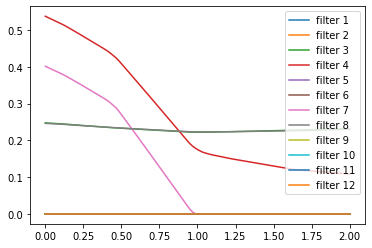

In [115]:
model.analysis.filter_kernel = Elimination(list(high_pass_indices))
model.analysis.filter._kernel = Elimination(list(high_pass_indices))

plot_filter_banks(kernel=model.analysis.filter._kernel)
evaluate(model, dataset.data)

Get correctly classified nodes by filterbanks - #10

In [ ]:
low_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test')


In [118]:
low_not_high_correct_nodes = dataset.data['test_mask'].nonzero().view(-1)[list(low_pass_correct_indices.difference(high_pass_correct_indices))]
high_not_low_correct_nodes = dataset.data['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.difference(low_pass_correct_indices))]

print('Number of node classified correctly by low-pass filters but not by high-pass filters:', len(low_not_high_correct_nodes))
print('Number of node classified correctly by high-pass filters but not by low-pass filters:', len(high_not_low_correct_nodes))

Prepare networkx graph for case study

In [120]:
from networkx import Graph
import networkx as nx
from scipy.sparse import coo_matrix
import numpy as np

# Build graph
adj = coo_matrix(
    (np.ones(dataset.data.num_edges),
    (dataset.data.edge_index[0].numpy(), dataset.data.edge_index[1].numpy())),
    shape=(dataset.data.num_nodes, dataset.data.num_nodes))
G = Graph(adj)


Draw attentions from high-pass filterbank(s)

In [ ]:
# high_attentions = torch.stack([att1[i] for i in high_pass_indices]).sum(dim=0)
high_attentions = att1[10]
node_colors = {0: 'red', 1: 'orange', 2: 'purple', 3: 'lime', 4: 'pink', 5: 'green', 6: 'black'}
node = high_not_low_correct_nodes[1].item()
Gego = nx.ego_graph(G, node, 2)
nx.draw(Gego,
    node_color=list(map(lambda n: node_colors[dataset.data.y[n].item()], Gego.nodes)),
    node_size=[ 300 if n == node else high_attentions[node, n]*1e7 for n in Gego.nodes],
    node_shape=['*' if n == node else 'o' for n in Gego.nodes],
    font_size=10,
    with_labels=False,
    linewidths=0.5)

Draw attentions from low-pass filterbank(s)

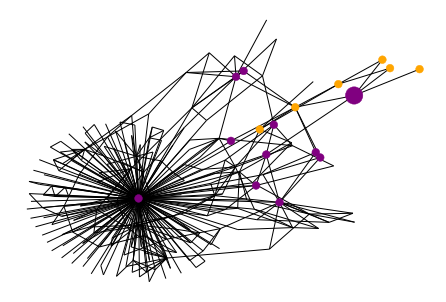

In [160]:
low_attentions = att1[8]
nx.draw(Gego,
    node_color=list(map(lambda n: node_colors[dataset.data.y[n].item()], Gego.nodes)),
    node_size=[ 300 if n == node else low_attentions[node, n]*1e7 for n in Gego.nodes],
    node_shape=['*' if n == node else 'o' for n in Gego.nodes],
    font_size=10,
    with_labels=False,
    linewidths=0.5)
